# ASHRAE - Great Energy Predictor III
### *How much energy will a building consume?*

## Entendimento do problema

### Enunciado

*In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.*

### Dados disponibilizados

**train.csv**
> * building_id - Foreign key for the building metadata.
> * meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
> * timestamp - When the measurement was taken
> * meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. 

**building_meta.csv**
> * site_id - Foreign key for the weather files.
> * building_id - Foreign key for training.csv
> * primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
> * square_feet - Gross floor area of the building
> * year_built - Year building was opened
> * floorcount - Number of floors of the building

**weather[train/test].csv** - Weather data from a meteorological station as close as possible to the site.

> * site_id
> * air_temperature - Degrees Celsius
> * cloud_coverage - Portion of the sky covered in clouds, in oktas
> * dew_temperature - Degrees Celsius
> * precip_depth_1_hr - Millimeters
sea_level_pressure - Millibar/hectopascals
> * wind_direction - Compass direction (0-360)
> * wind_speed - Meters per second

**test.csv**

> * row_id - Row id for your submission file
> * building_id - Building id code
> * meter - The meter id code
> * timestamp - Timestamps for the test data period

### Métrica de avaliação

*Root Mean Squared Logarithmic Error*



In [1]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_test,predictions):
    score = np.sqrt(mean_squared_log_error(y_test, predictions))
    return score

## Preparação dos dados

### Importação das bibliotecas e arquivos externos a serem utilizados.

In [2]:
import pandas as pd 
import numpy as np
import seabord as sns
from functions import *

### Carga dos dados

In [3]:
path = "./Data/"

In [4]:
building_meta = pd.read_csv(path+"building_metadata.csv")
weather_train = pd.read_csv(path+"weather_train.csv")
#weather_test = pd.read_csv(path+"weather_test.csv")
train_set = pd.read_csv(path+"train.csv")
#test_set = pd.read_csv(path+"test.csv")

### Tratamento inicial dos dados

In [5]:
print("Size of {:>20s} {:>8} rows, {:>2} columns / Mem. usage: {:7.2f} Mb".format("train_set data:",train_set.shape[0],train_set.shape[1],train_set.memory_usage().sum()/1024**2))
# print("Size of {:>20s} {:>8} rows, {:>2} columns / Mem. usage: {:7.2f} Mb".format("test_set data:",test_set.shape[0],test_set.shape[1],test_set.memory_usage().sum()/1024**2))
print("Size of {:>20s} {:>8} rows, {:>2} columns / Mem. usage: {:7.2f} Mb".format("weather_train data:",weather_train.shape[0],weather_train.shape[1],weather_train.memory_usage().sum()/1024**2))
# print("Size of {:>20s} {:>8} rows, {:>2} columns / Mem. usage: {:7.2f} Mb".format("weather_test data:",weather_test.shape[0],weather_test.shape[1],weather_test.memory_usage().sum()/1024**2))
print("Size of {:>20s} {:>8} rows, {:>2} columns / Mem. usage: {:7.2f} Mb".format("building_meta data:",building_meta.shape[0],building_meta.shape[1],building_meta.memory_usage().sum()/1024**2))

Size of      train_set data: 20216100 rows,  4 columns / Mem. usage:  616.95 Mb
Size of  weather_train data:   139773 rows,  9 columns / Mem. usage:    9.60 Mb
Size of  building_meta data:     1449 rows,  6 columns / Mem. usage:    0.07 Mb


### Redução do uso de memória

Aplicação de script para redução de algarismos reduntantes para auxiliar na redução do uso de memória local.

In [6]:
train_set = reduce_mem_usage(train_set)
# train_set = reduce_mem_usage(train_set)
weather_train = reduce_mem_usage(weather_train)
# weather_test = reduce_mem_usage(weather_test)
building_meta = reduce_mem_usage(building_meta)

Mem. usage decreased to  289.19 Mb (53.1% reduction)
Mem. usage decreased to    3.07 Mb (68.1% reduction)
Mem. usage decreased to    0.03 Mb (60.3% reduction)


## Análise dos dados inicial

### Prévia dos dataframes

In [7]:
train_set.head()

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

In [8]:
weather_train.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00        25.000000             6.0   
1        0  2016-01-01 01:00:00        24.406250             NaN   
2        0  2016-01-01 02:00:00        22.796875             2.0   
3        0  2016-01-01 03:00:00        21.093750             2.0   
4        0  2016-01-01 04:00:00        20.000000             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0         20.00000                NaN              1019.5             0.0   
1         21.09375               -1.0              1020.0            70.0   
2         21.09375                0.0              1020.0             0.0   
3         20.59375                0.0              1020.0             0.0   
4         20.00000               -1.0              1020.0           250.0   

   wind_speed  
0    0.000000  
1    1.500000  
2    0.000000  
3    0.000000  
4    2.599609

In [9]:
building_meta.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

### Verificação de valores vazios e NaN

In [10]:
total = train_set.isnull().sum()
percent = (train_set.isnull().sum()/train_set.isnull().count()*100)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

Total  Percent
building_id        0      0.0
meter              0      0.0
timestamp          0      0.0
meter_reading      0      0.0

In [11]:
total = weather_train.isnull().sum()
percent = (weather_train.isnull().sum()/weather_train.isnull().count()*100)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data

Total    Percent
site_id                 0   0.000000
timestamp               0   0.000000
air_temperature        55   0.039350
cloud_coverage      69173  49.489529
dew_temperature       113   0.080845
precip_depth_1_hr   50289  35.979052
sea_level_pressure  10618   7.596603
wind_direction       6268   4.484414
wind_speed            304   0.217496

In [12]:
total = building_meta.isnull().sum()
percent = (building_meta.isnull().sum()/building_meta.isnull().count()*100)
missing_building_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_data

Total    Percent
site_id          0   0.000000
building_id      0   0.000000
primary_use      0   0.000000
square_feet      0   0.000000
year_built     774  53.416149
floor_count   1094  75.500345

## Tratamento secundário dos dados

Codificação de artibutos categóricos, preenchimento de valores faltantes, etc.

### Lidando com dados faltantes

In [13]:
building_meta['floor_count'] = building_meta['floor_count'].fillna(-999).astype(np.int16)

building_meta['year_built'] = building_meta['year_built'].fillna(building_meta['year_built'].min()-100).astype(np.int16)

# train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)

weather_train['cloud_coverage'] = weather_train['cloud_coverage'].fillna(-999).astype(np.int16)
# weather_test['cloud_coverage'] = weather_test['cloud_coverage'].fillna(-999).astype(np.int16) 

# weather_test['wind_direction'] = weather_test['wind_direction'].fillna(0.0) # review method
weather_train['wind_direction'] = weather_train['wind_direction'].fillna(0.0) # review method

### Atributos categóricos

In [14]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
building_meta['primary_use'] = labelEncoder.fit_transform(building_meta['primary_use'])

Codificação da coluna *wind_direction* em relação a Rosa dos Ventos e adição de coluna categórica em relação a Escala de Beufort.

In [15]:
weather_train = average_imputation(weather_train, 'wind_speed')
weather_train = average_imputation(weather_train, 'wind_direction')

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    weather_train.loc[(weather_train['wind_speed']>=item[1]) & (weather_train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

weather_train['wind_direction'] = weather_train['wind_direction'].apply(degToCompass)
weather_train['beaufort_scale'] = weather_train['beaufort_scale'].astype(np.uint8)
weather_train["wind_direction"] = weather_train['wind_direction'].astype(np.uint8)
    
    
# weather_test = average_imputation(weather_test, 'wind_speed')
# weather_test = average_imputation(weather_test, 'wind_direction')

# for item in beaufort:
#     weather_test.loc[(weather_test['wind_speed']>=item[1]) & (weather_test['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

# weather_test['wind_direction'] = weather_test['wind_direction'].apply(degToCompass)
# weather_test['wind_direction'] = weather_test['wind_direction'].apply(degToCompass)
# weather_test['beaufort_scale'] = weather_test['beaufort_scale'].astype(np.uint8)
# weather_test["wind_direction"] = weather_test['wind_direction'].astype(np.uint8)
# test_set["meter"] = test_set['meter'].astype(np.uint8)
# test_set["site_id"] = test_set['site_id'].astype(np.uint8)

### Configuração de *dtype*

In [27]:
# train_set["meter"] = train_set['meter'].astype(np.uint8)
# train_set["site_id"] = train_set['site_id'].astype(np.uint8)

# test_set["meter"] = test_set['meter'].astype(np.uint8)
# test_set["site_id"] = test_set['site_id'].astype(np.uint8)

building_meta["year_built"] = building_meta["year_built"].astype('int32')

### Configuração de data

In [28]:
train_set["timestamp"] = pd.to_datetime(train_set["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S')

train_set["hour"] = train_set["timestamp"].dt.hour
train_set["day"] = train_set["timestamp"].dt.day
train_set["weekend"] = train_set["timestamp"].dt.weekday
train_set["month"] = train_set["timestamp"].dt.month
train_set = add_holiday(train_set)

# test_set["timestamp"] = pd.to_datetime(test_set["timestamp"], format='%Y-%m-%d %H:%M:%S')
# weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S')

# test_set["hour"] = test_set["timestamp"].dt.hour
# test_set["day"] = test_set["timestamp"].dt.day
# test_set["weekend"] = test_set["timestamp"].dt.weekday
# test_set["month"] = test_set["timestamp"].dt.month
# test_set = add_holiday(test_set)

# age_2016 corresponds to building age in train data
building_meta['age_2016'] = 2017 - building_meta['year_built'] + 1 # age 218 corresponds to NaN values before input
# age_2017 corresponds to building age in test data
building_meta['age_2017'] = 2017 - building_meta['year_built'] + 1 # age 218 corresponds to NaN values before input

## Análise de dados exploratória

### Criação do DataFrame de treino completo

In [29]:
tempTrain = pd.merge(train_set,building_meta,on='building_id')
fullTrain = pd.merge(tempTrain,weather_train,on=['site_id','timestamp'])
del tempTrain # reduce memory usage

In [30]:
fullTrain.head()

building_id  meter  timestamp  meter_reading  hour  day  weekend  month  \
0            0      0 2016-01-01            0.0     0    1        4      1   
1            1      0 2016-01-01            0.0     0    1        4      1   
2            2      0 2016-01-01            0.0     0    1        4      1   
3            3      0 2016-01-01            0.0     0    1        4      1   
4            4      0 2016-01-01            0.0     0    1        4      1   

   holiday  site_id       ...        age_2016  age_2017  air_temperature  \
0        1        0       ...              10        10             25.0   
1        1        0       ...              14        14             25.0   
2        1        0       ...              27        27             25.0   
3        1        0       ...              16        16             25.0   
4        1        0       ...              43        43             25.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0               6             20.0                NaN              1019.5   
1               6             20.0                NaN              1019.5   
2               6             20.0                NaN              1019.5   
3               6             20.0                NaN              1019.5   
4               6             20.0                NaN              1019.5   

   wind_direction  wind_speed  beaufort_scale  
0               0         0.0               0  
1               0         0.0               0  
2               0         0.0               0  
3               0         0.0               0  
4               0         0.0               0  

[5 rows x 24 columns]

### Visualização dos dados em gráficos

### Consumo comparativo por tipo de leitor

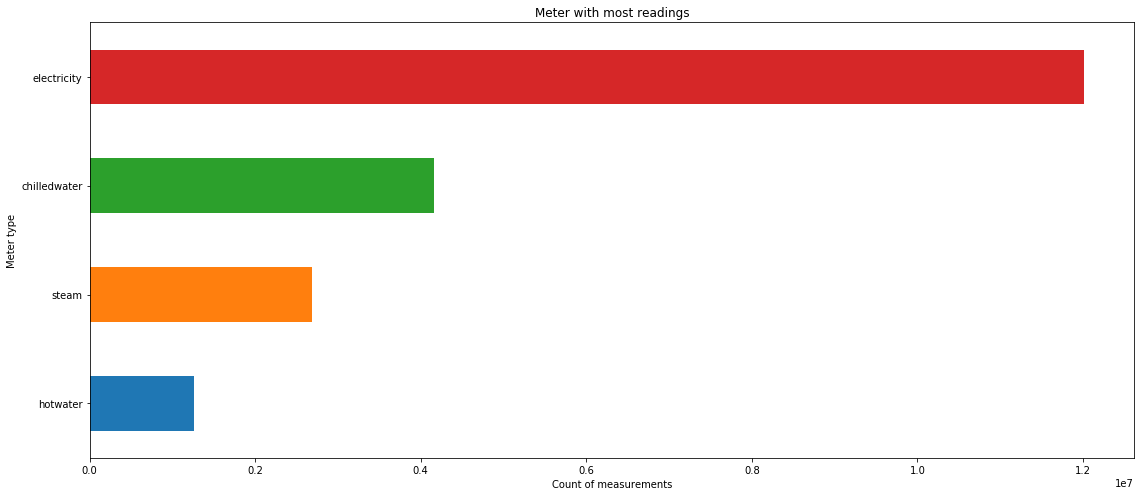

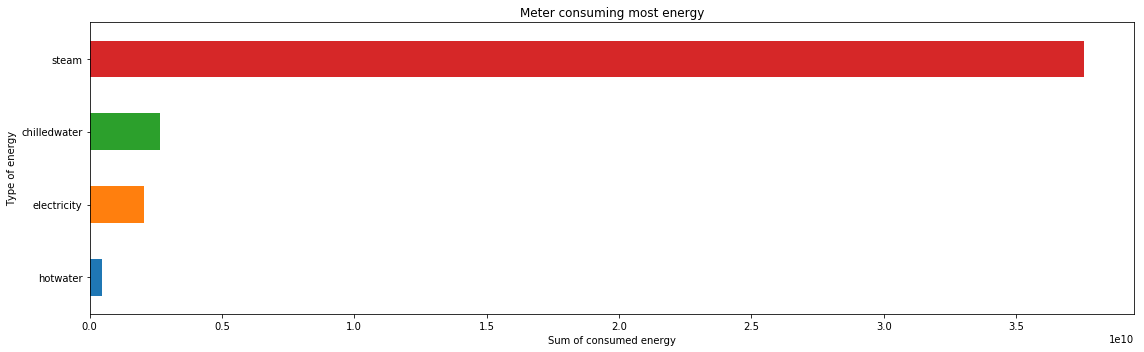

In [41]:
energy_types_dict = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
energy_types      = ['electricity', 'chilledwater', 'steam', 'hotwater']

plt.figure(figsize=(16,7))
tmp_df = fullTrain.meter.value_counts()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Meter with most readings")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()
del tmp_df # reduce memory usage

plt.figure(figsize=(16,5))
tmp_df = fullTrain.groupby("meter").meter_reading.sum()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Meter consuming most energy")
plt.xlabel("Sum of consumed energy")
plt.ylabel(f"Type of energy")
plt.tight_layout()
plt.show()
del tmp_df # reduce memory usage

In [65]:
### Análise da distribuição de consumo medido por tipo de leitor

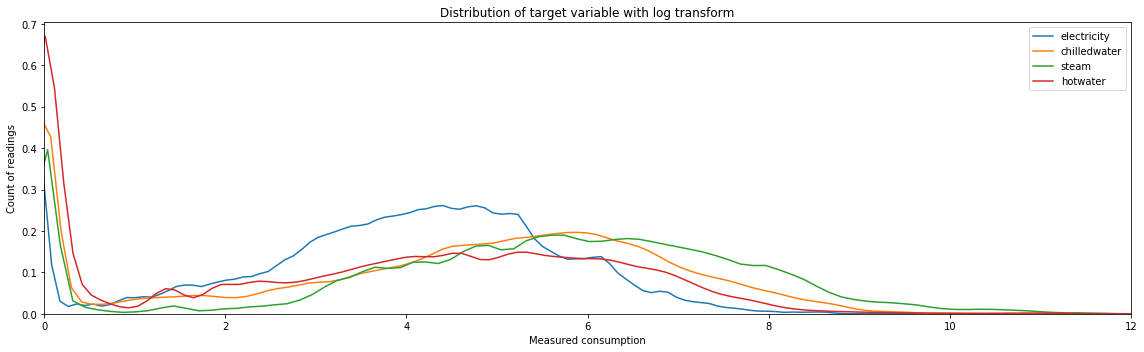

In [42]:
plt.figure(figsize=(16,5))
for idx in range(0,4):
    sns.distplot(np.log1p(fullTrain[fullTrain.meter==idx].meter_reading), hist=False, label=energy_types[idx])
plt.title(f"Distribution of target variable with log transform")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.legend()
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

### Distribuição de consumo total por *primary_use*m

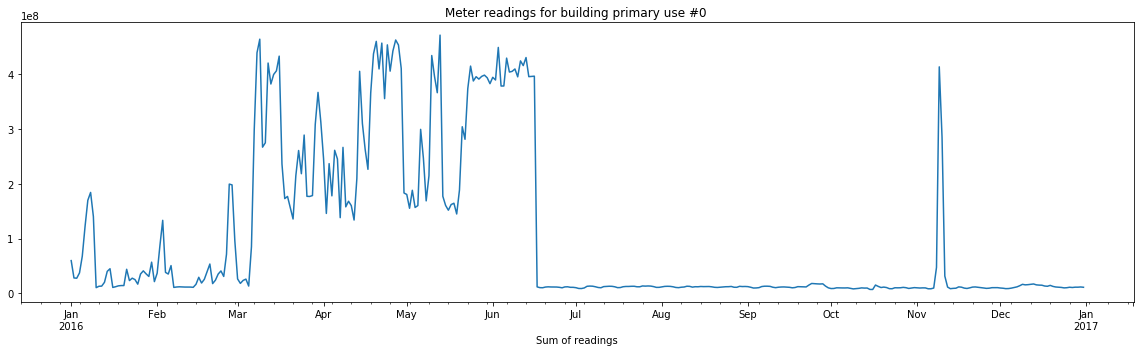

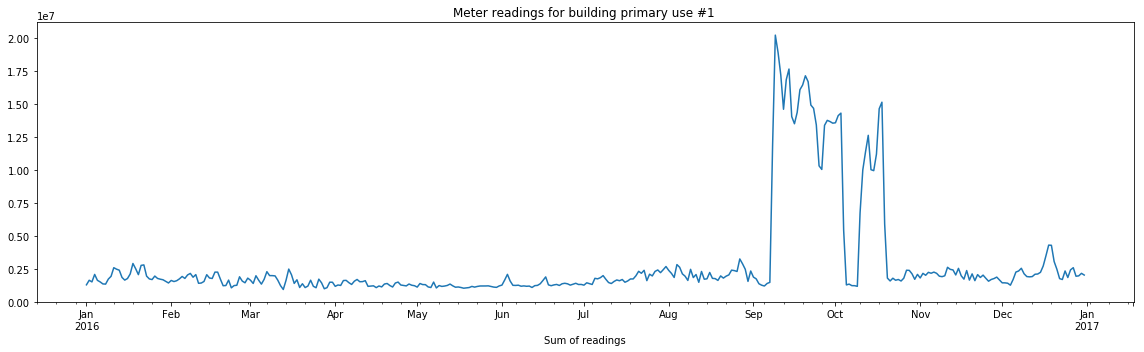

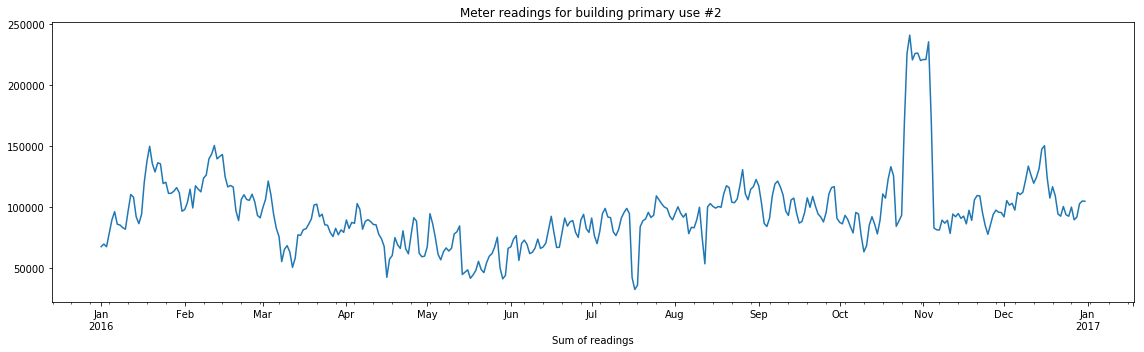

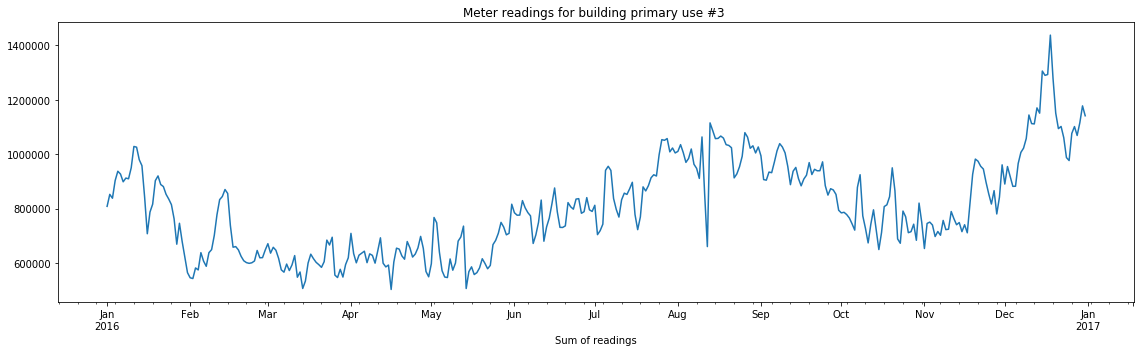

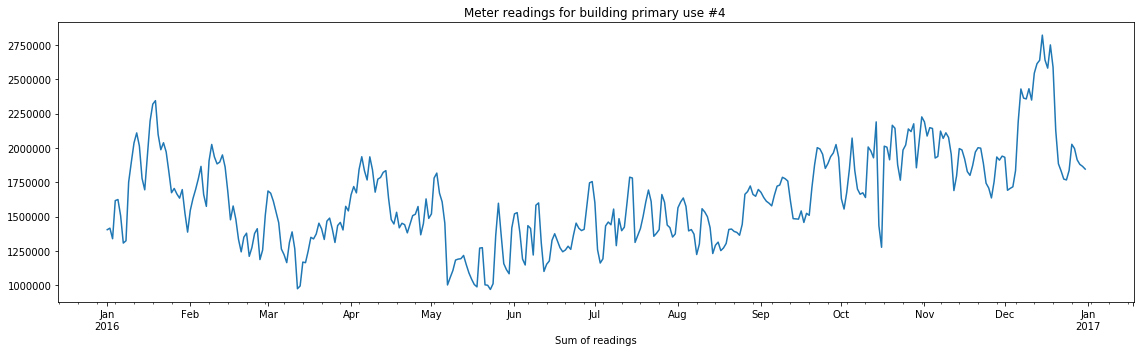

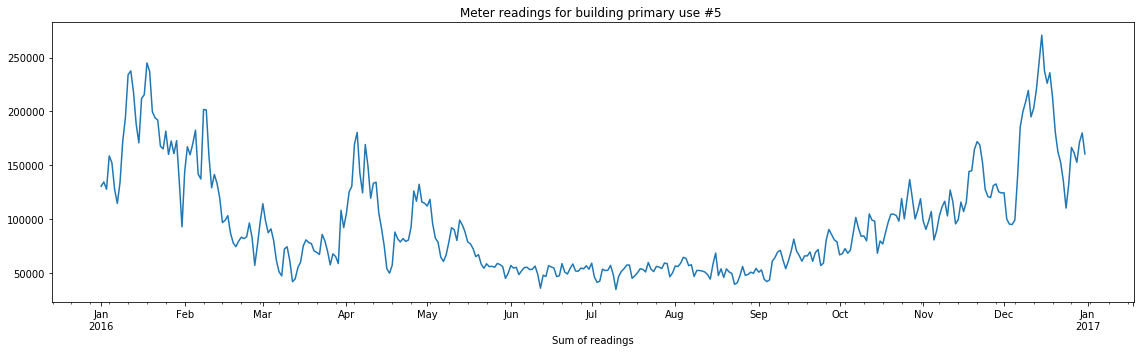

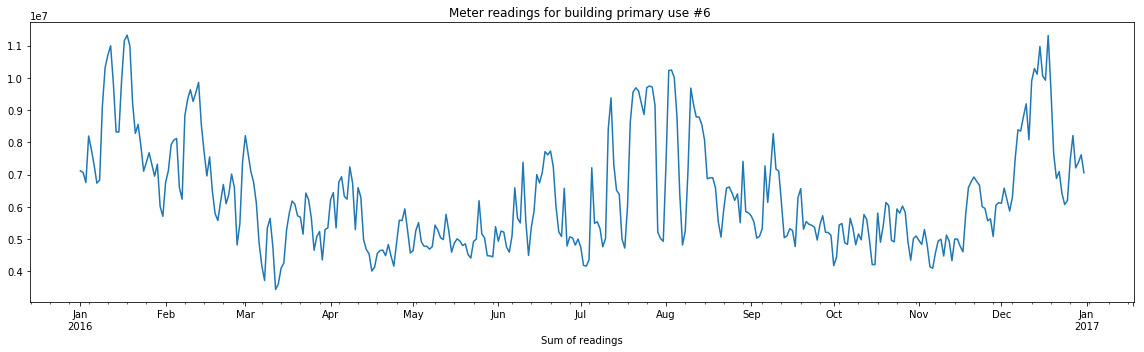

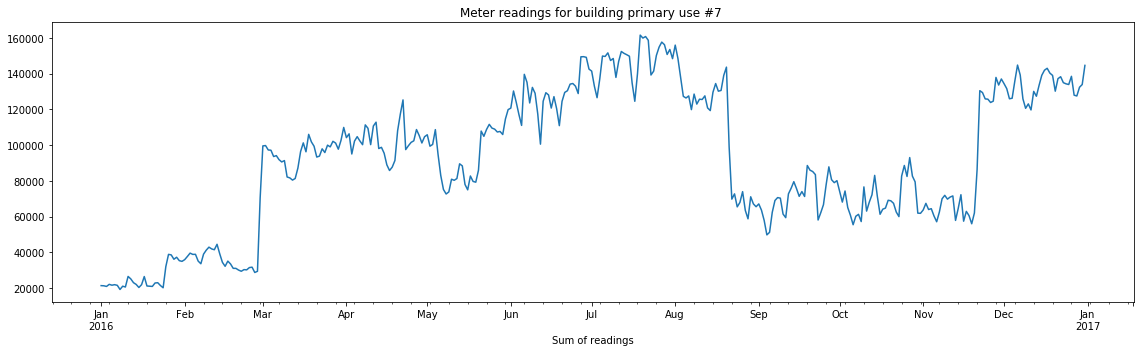

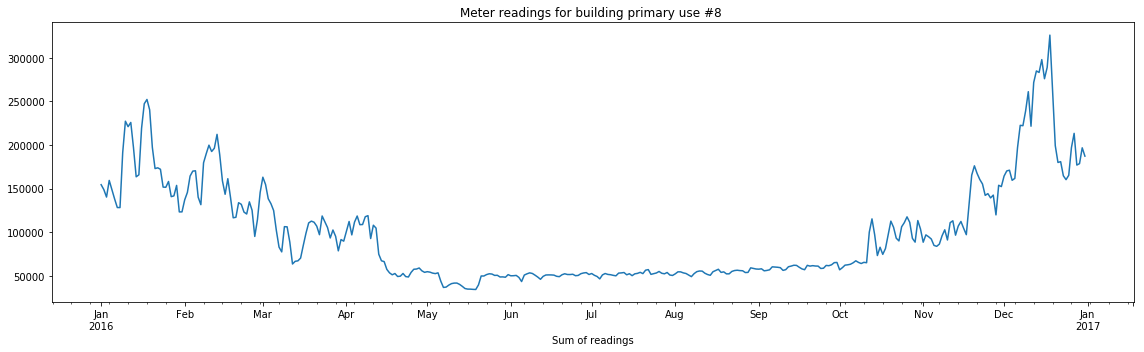

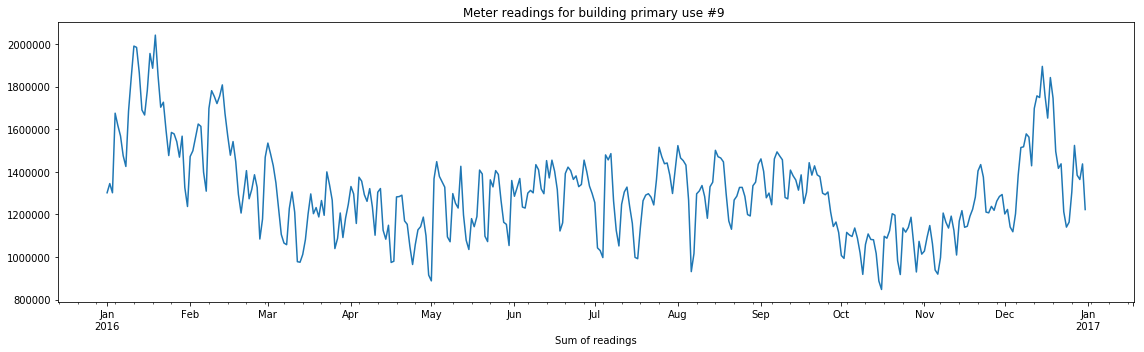

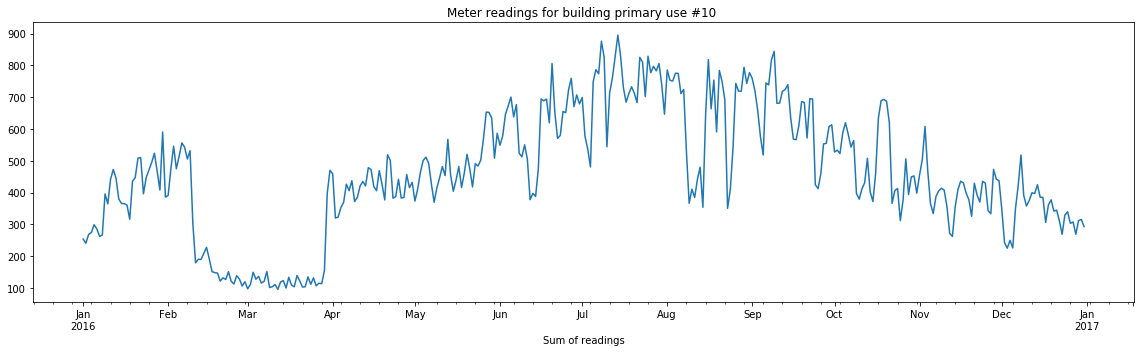

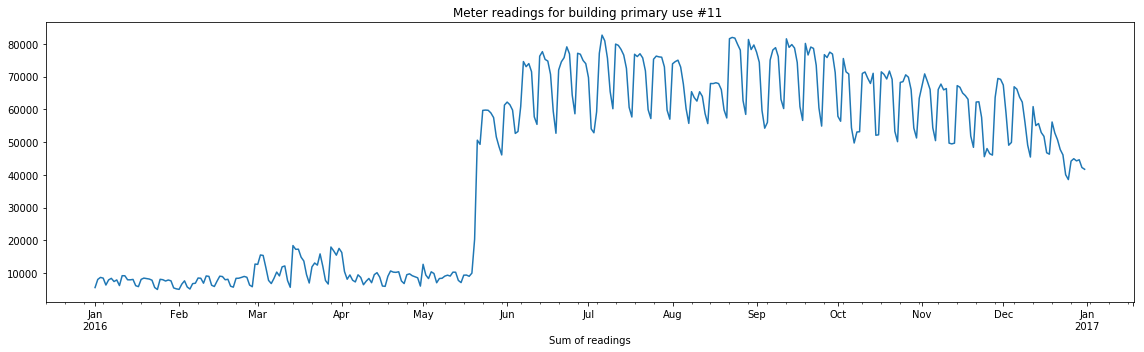

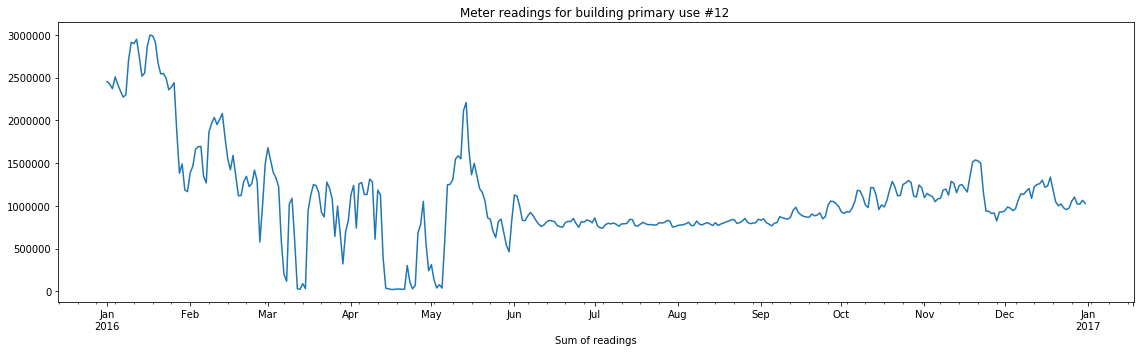

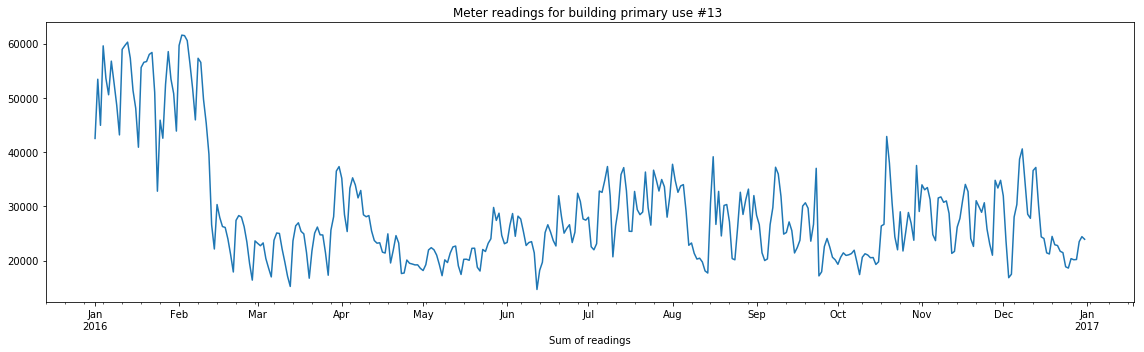

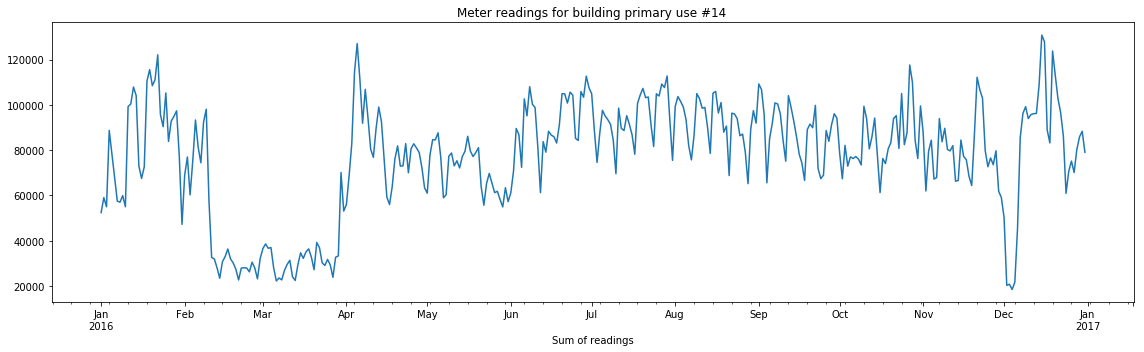

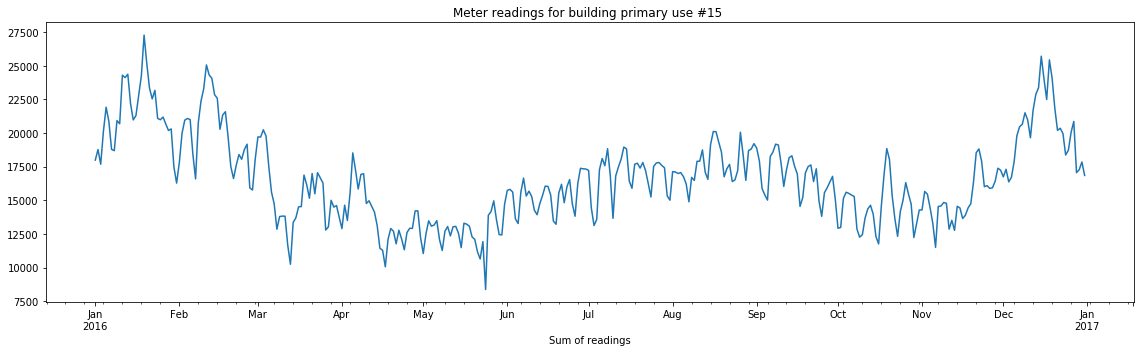

In [57]:
for bldg_id in fullTrain['primary_use'].value_counts().index.sort_values():
    plt.figure(figsize=(16,5))
    tmp_df = fullTrain[fullTrain.primary_use == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building primary use #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()
    del tmp_df # reduce memory usage

### Consumo comparativo por *primary_use*

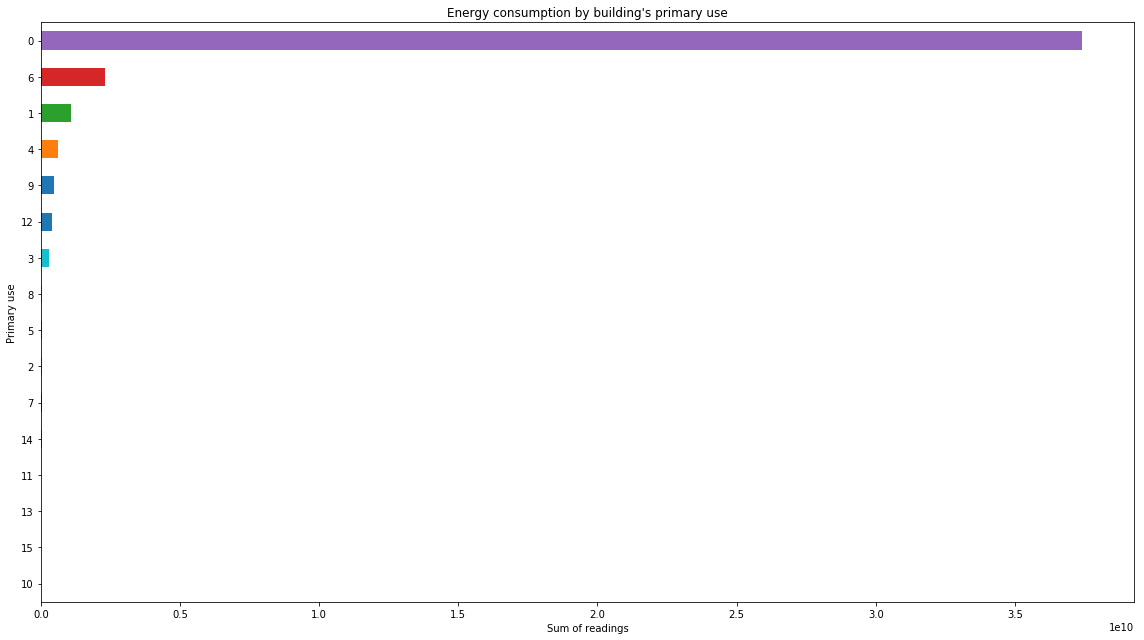

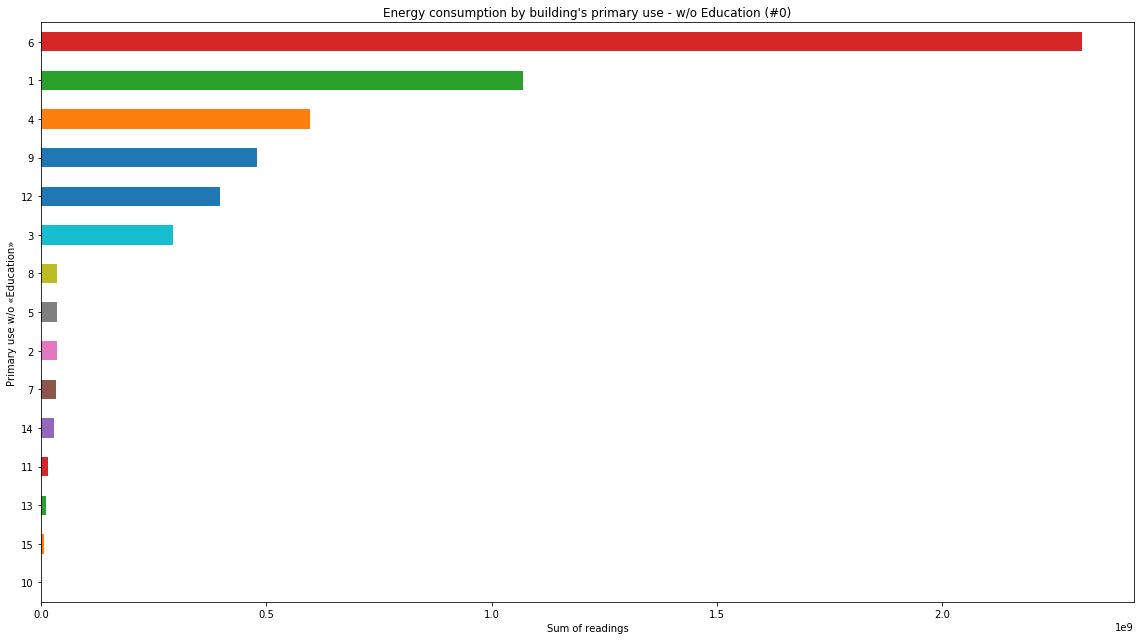

In [60]:
tmp_df = fullTrain.groupby("primary_use").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
tmp_df.plot(kind="barh")
plt.title(f"Energy consumption by building's primary use")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
tmp_df[:-1].plot(kind="barh")
plt.title(f"Energy consumption by building's primary use - w/o Education (#0)")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use w/o «Education»")
plt.tight_layout()
plt.show()

### Distribuição da média de medidas por *primary_use*

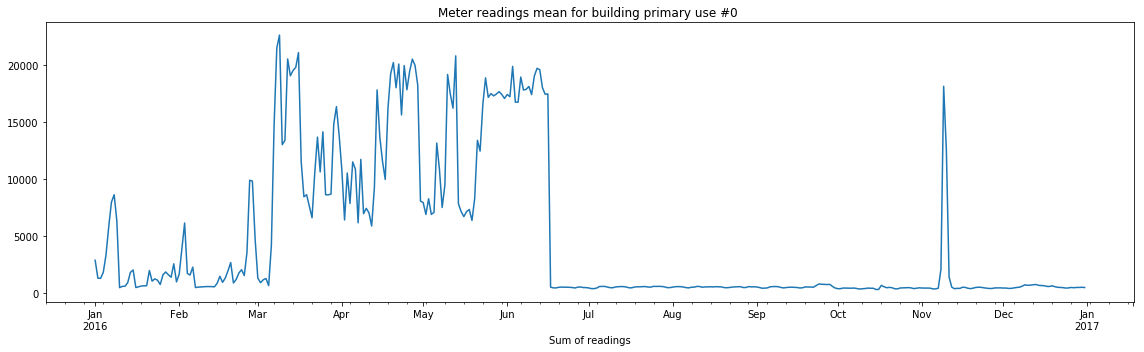

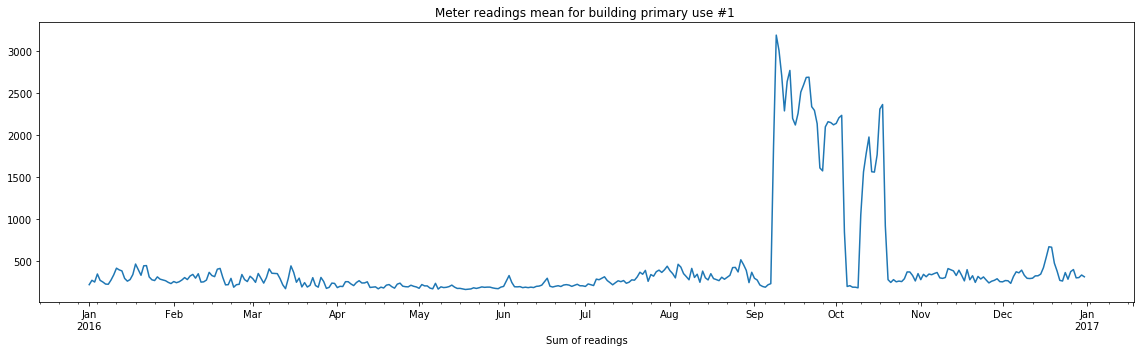

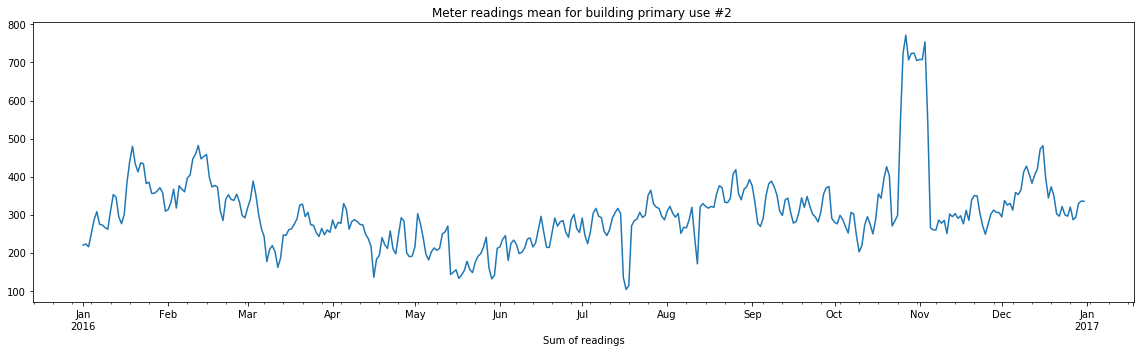

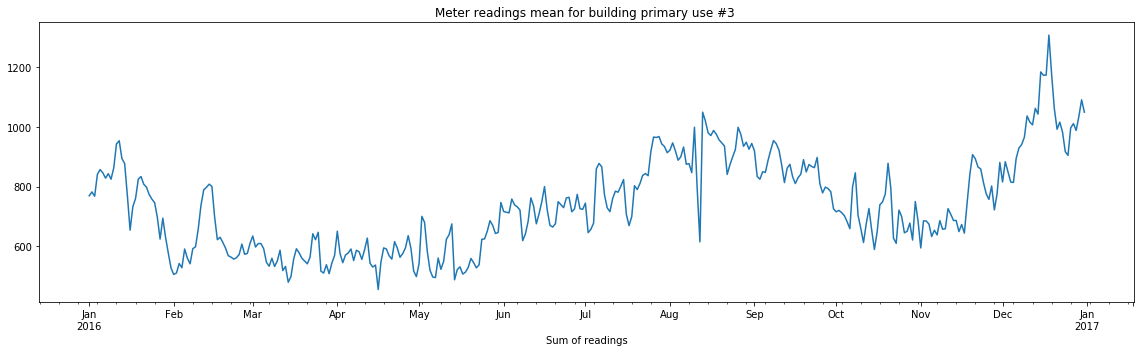

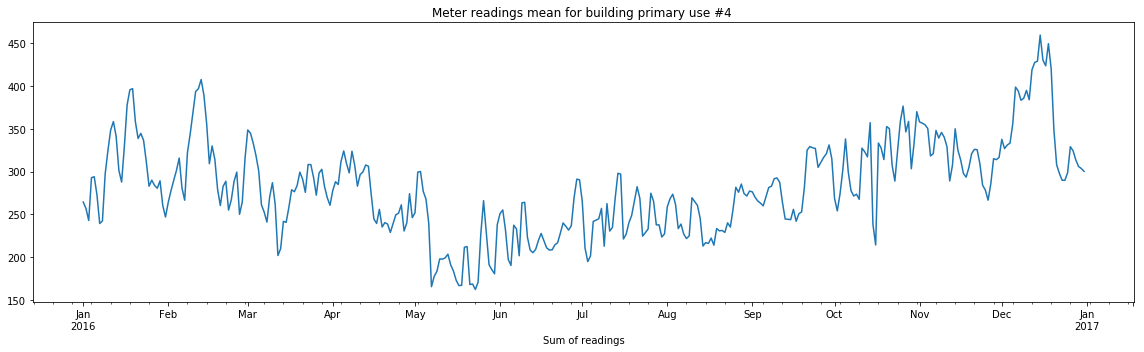

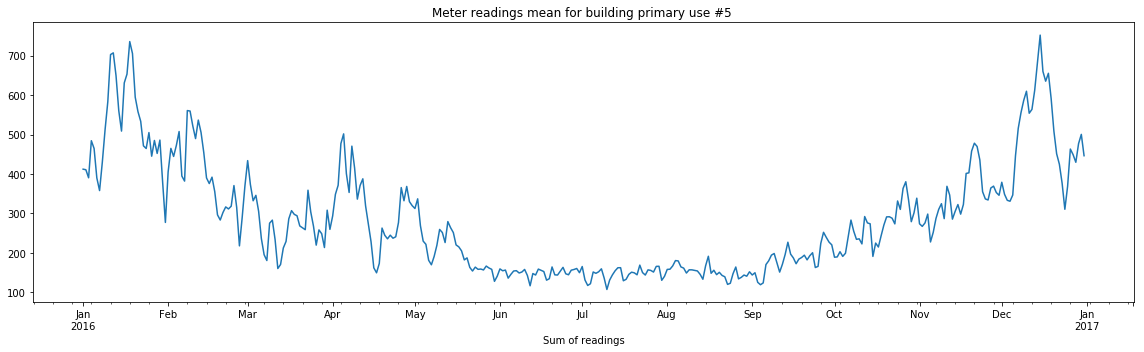

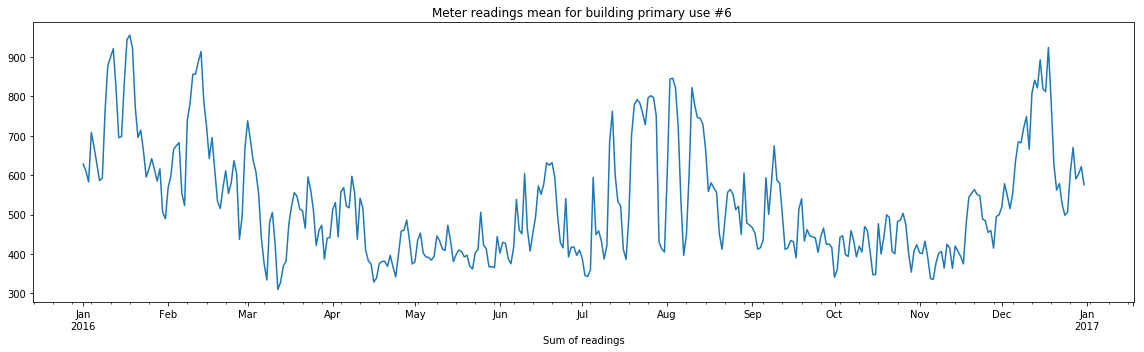

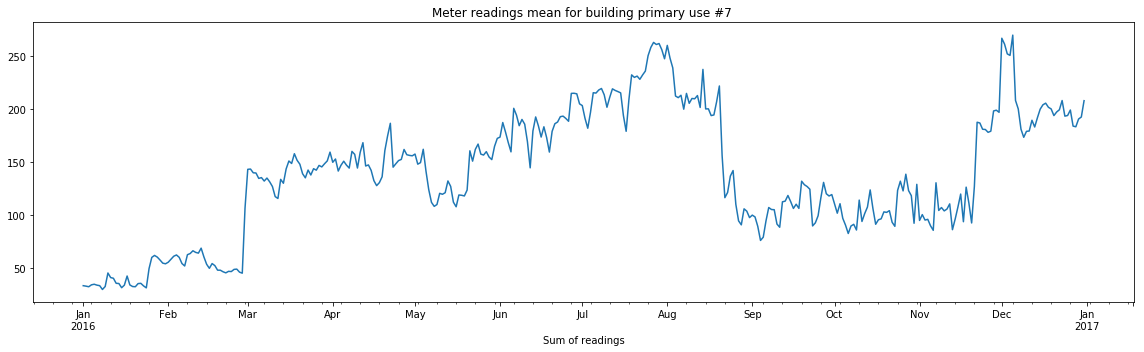

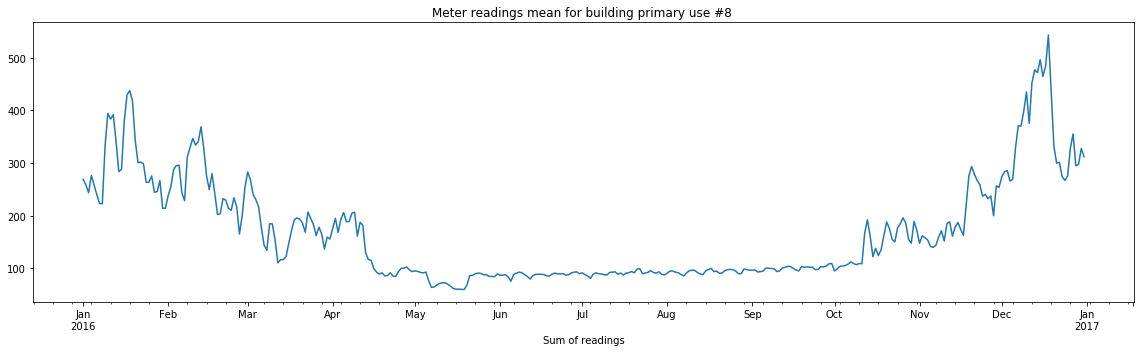

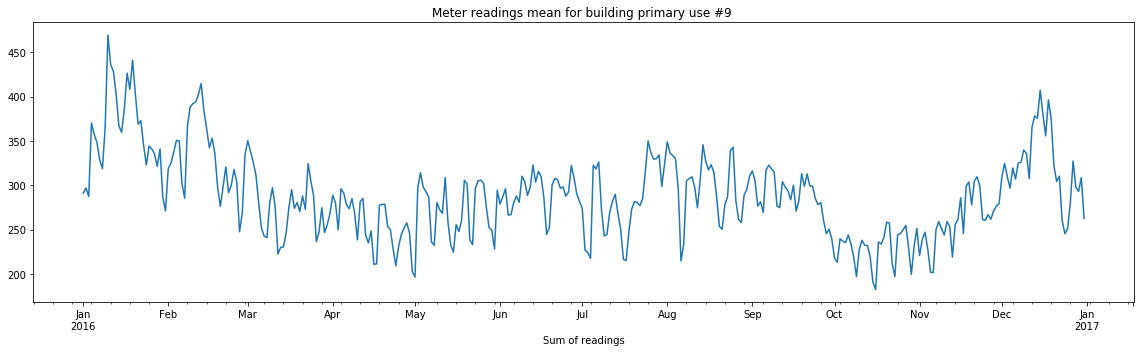

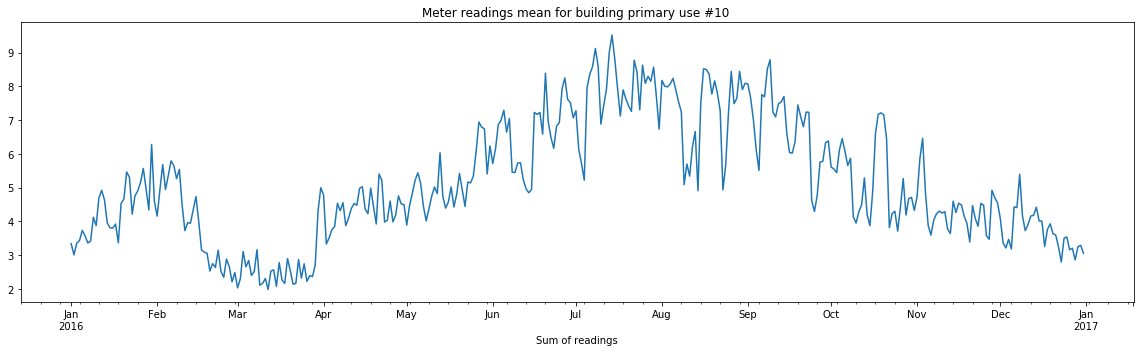

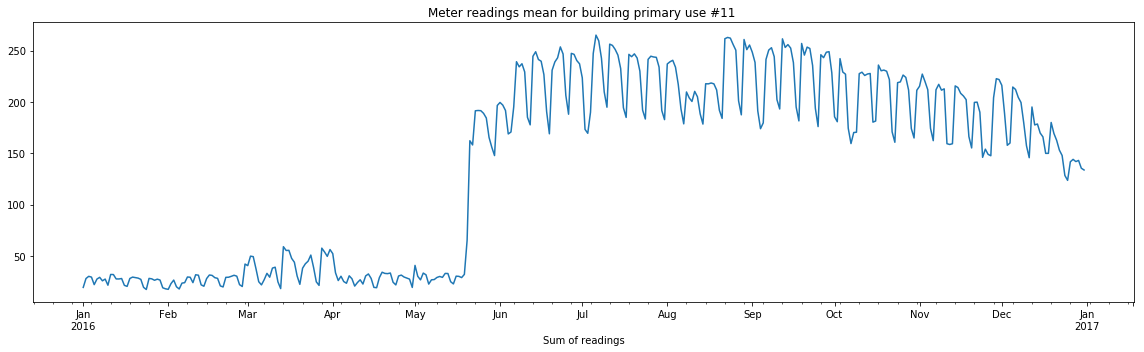

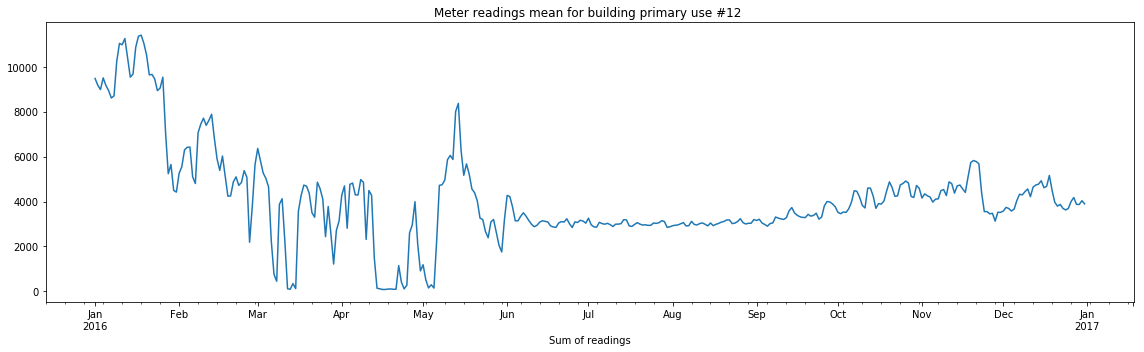

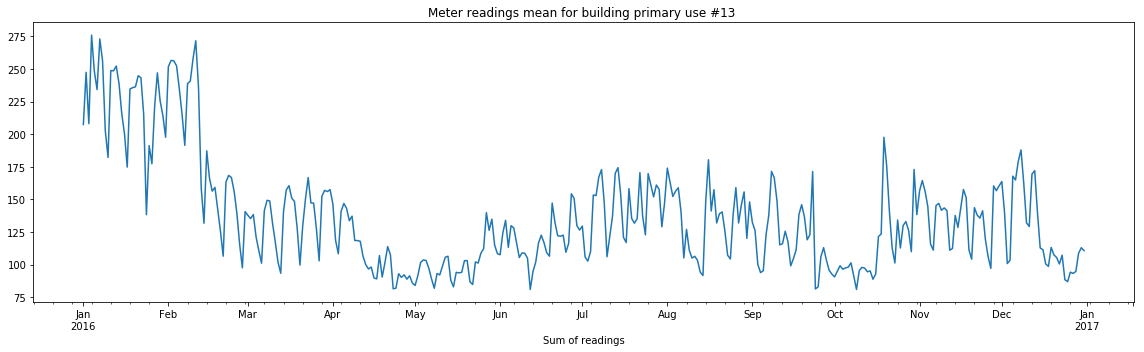

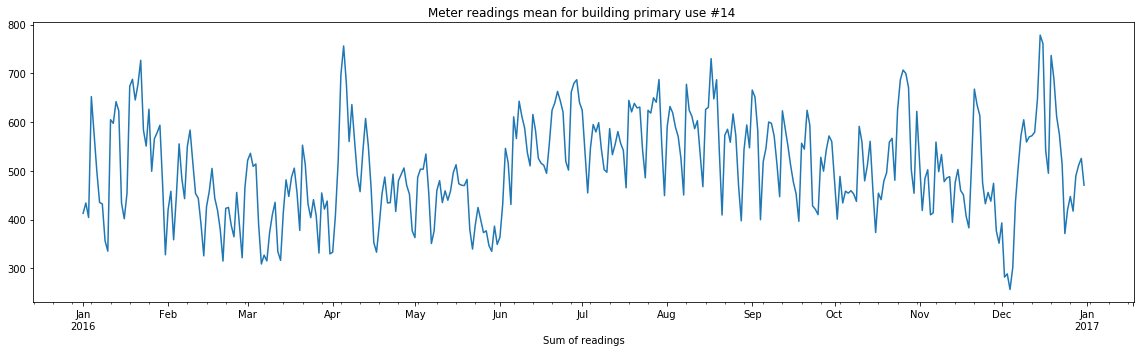

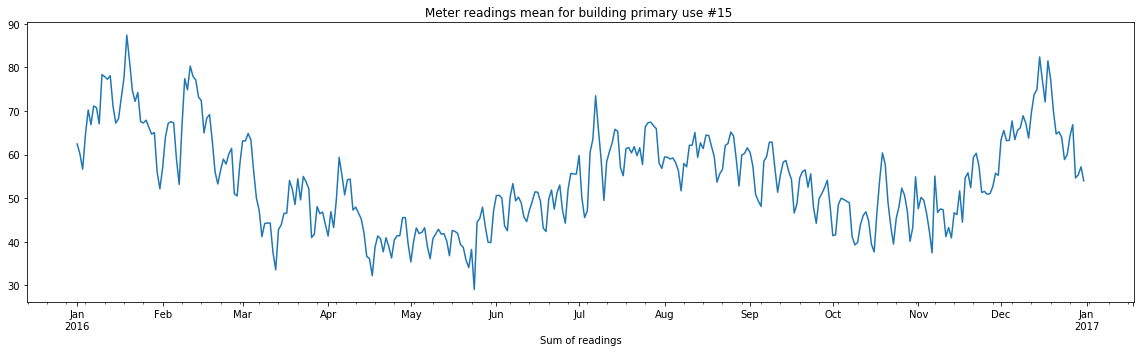

In [62]:
for bldg_id in fullTrain['primary_use'].value_counts().index.sort_values():
    plt.figure(figsize=(16,5))
    tmp_df = fullTrain[fullTrain.primary_use == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.mean().plot()
    plt.title(f"Meter readings mean for building primary use #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()
    del tmp_df # reduce memory usage

### Distribuição total da média de medidas

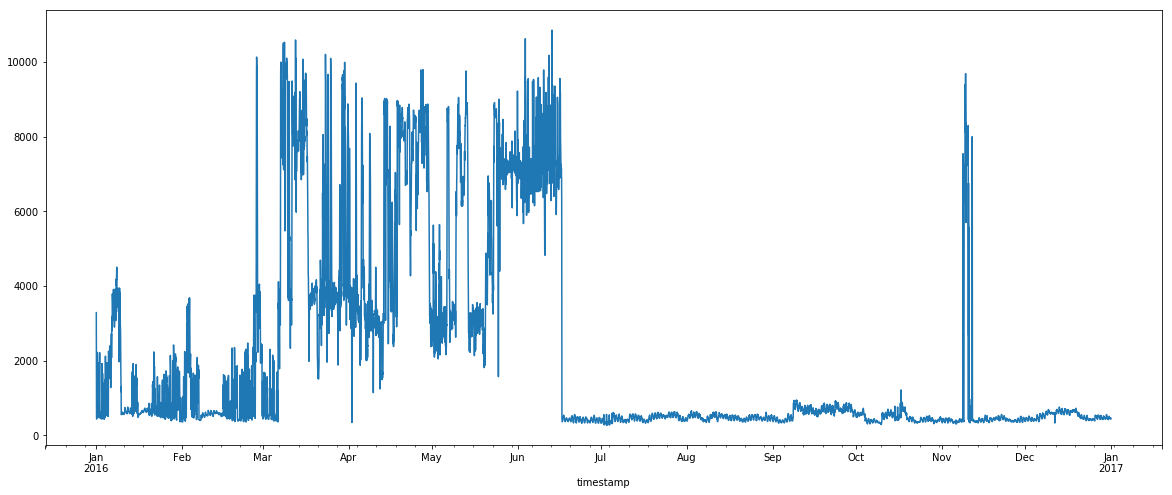

In [64]:
y_mean_time = fullTrain.groupby("timestamp").meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

## Seleção de Atributos

**Filter methods:**
> * information gain
> * chi-square test
> * correlation coefficient
> * variance threshold

**Wrapper methods:**
> * recursive feature elimination
> * sequential feature selection algorithms

**Embedded methods:**
> * L1 (LASSO) regularization
> * decision tree

## Treino e Validação

In [33]:
from sklearn.model_selection import cross_val_score

In [32]:
# tempTest = pd.merge(test_set,building_meta,on='building_id')
# fullTest = pd.merge(tempTest,weather_test,on=['site_id','timestamp'])
# del tempTest # reduce memory usage

In [34]:
# actual = pd.read_csv(path+"verification.csv")
# actual = reduce_mem_usage(actual)